In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from spicy_snow.processing.s1_preprocessing import s1_dB_to_power

from scipy.stats import pearsonr
from scipy.stats import linregress

from xrspatial import aspect, slope

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [19]:
dss = {fp.stem:xr.open_dataset(fp) for fp in Path('~/scratch/spicy/SnowEx-Data').expanduser().glob('*.nc')}
for ds in dss.values():
    ds['aspect'] = aspect(ds['lidar-dem'])

lidar-sd
Slope: -0.1240680617172739. p: 6.35638083379357e-05
fcf
Slope: 0.04497243231449199. p: 1.0507390375689126e-18
lidar-dem
Slope: -0.00018498232557125335. p: 8.255235629826667e-06
aspect
Slope: 0.002105358096984392. p: 1.2939391211372324e-06


/tmp/ipykernel_17319/3833632406.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


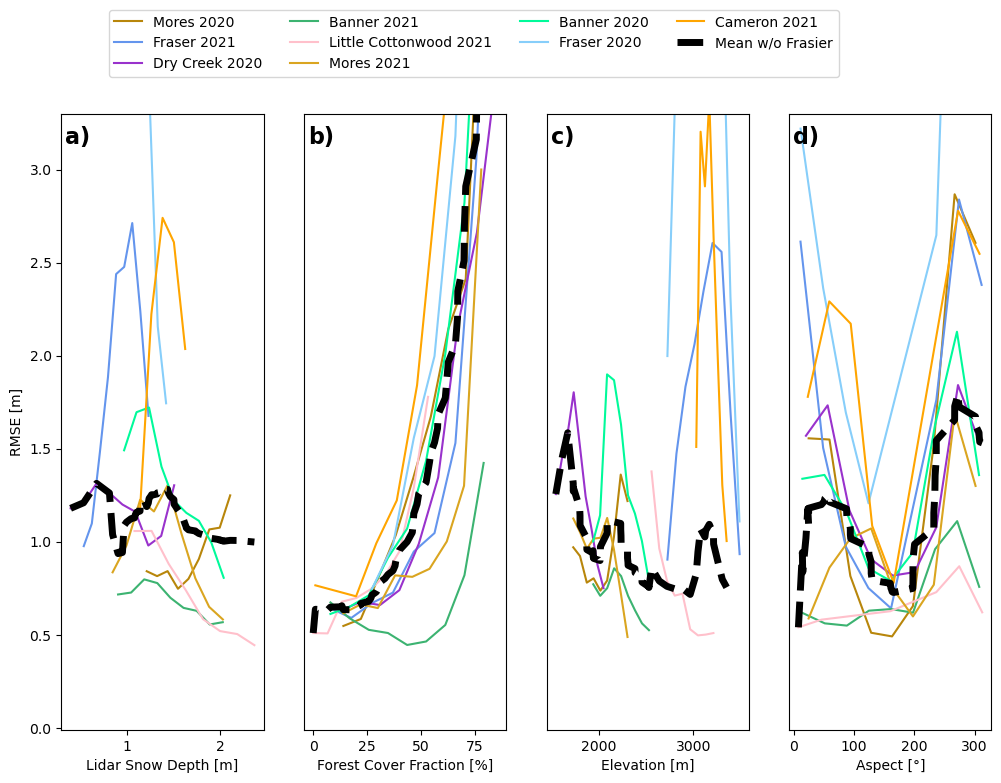

In [25]:
fig, axes = plt.subplots(1, 4, figsize = (12,8))

loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

x_labels = {'lidar-sd': 'Lidar Snow Depth [m]', 'fcf':'Forest Cover Fraction [%]', 'lidar-dem': 'Elevation [m]', 'aspect':'Aspect [°]'} # 'lidar-dem': 'Elevation [m]', , 'lidar-vh': 'Tree Height [m]'

for (var, label), ax in zip(x_labels.items(), axes.ravel()):

    ss = []
    f_ss = []
    for stem, ds in dss.items():
        # if 'Frasier' in stem.split('-')[0].replace('_', ' ') or 'Cameron' in stem:
            # continue
        # ds = ds.where(ds['wet_snow'] == 0)

        if var == 's1':
            time_ds = ds.sel(band = 'inc')
            time_ds['s1'] = time_ds['s1'].isel(time = slice(len(np.unique(time_ds.relative_orbit)))).mean(dim = 'time')
            # time_ds = time_ds.where(time_ds['lidar-dem'] > time_ds['lidar-dem'].quantile(0.5))

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        res = pd.Series(dtype = float)

        for cat, sub in time_ds.sel(band = 'inc').groupby_bins(var, np.linspace(*time_ds.sel(band = 'inc')[var].quantile([0.05, 0.95]).values.ravel(), 10)):

            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))

            if len(x[idx]) < 100:
                continue

            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx]) / np.nanmean(y[idx])

            if var == 's1':
                res.loc[np.rad2deg(cat.left)] = rmse_result / np.nanmean(x)
            elif var == 'lidar-sd':
                res.loc[cat.left] = rmse_result #/ np.nanmean(x)
            elif var == 'fcf':
                res.loc[cat.left * 100] = rmse_result
            else:
                res.loc[cat.left] = rmse_result
                    
        res.sort_index().plot(ax= ax, color = loc_colors[stem], label = stem.split('-')[0].replace('_', ' ').replace('Frasier', 'Fraser'))
        if 'Frasier' not in stem.split('-')[0].replace('_', ' '): # and 'Cameron' not in stem:
            ss.append(res.sort_index())
        else:
            f_ss.append(res.sort_index())
    
    # add mean line
    # vs = [10, 20, 30, 40,50, 60]
    # ss_new = [s.append(pd.Series({v:np.nan for v in vs})) for s in ss]
    if var == 'fcf':
        ss.extend(f_ss)
        df = pd.concat(ss, axis = 1).sort_index()
        df.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Mean - Frasier')
    else:
        df = pd.concat(ss, axis = 1).sort_index()
        df_f = pd.concat(f_ss, axis = 1).sort_index()
        df.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Mean w/o Frasier')
        # df_f.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Frasier')

    ax.set_xlabel(label)
    ax.set_ylim(-0.01, 3.3)
    print(var)
    # print((df.interpolate().mean(axis = 1).iloc[-1] - df.interpolate().mean(axis = 1).iloc[0])/ (df.interpolate().mean(axis = 1).index[-1] - df.interpolate().mean(axis = 1).index[0]))
    lm = linregress(x = df.interpolate().mean(axis = 1).index, y = df.interpolate().mean(axis = 1).values)
    print(f'Slope: {lm.slope}. p: {lm.pvalue}')
# axes[0].set_ylabel('NRMSE [m]')
axes[0].set_ylabel('RMSE [m]')
axes[0].legend(loc='upper left',
    bbox_to_anchor=(0.2, 1.18),
    ncol=4,
    # borderaxespad=0.15, 
    # fontsize=8,
    # frameon=False,
)

for ax in axes[1:]:
    ax.set_yticks([])

for ax, letter in zip(axes, ['a','b','c', 'd']):
    ax.text(0.02, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)


plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors/rmse_binned.png')

lidar-sd
Slope: -0.1240680617172739. p: 6.35638083379357e-05
fcf
Slope: 0.04497243231449199. p: 1.0507390375689126e-18
s1
Slope: -0.002547176188200319. p: 0.00013073127016988837


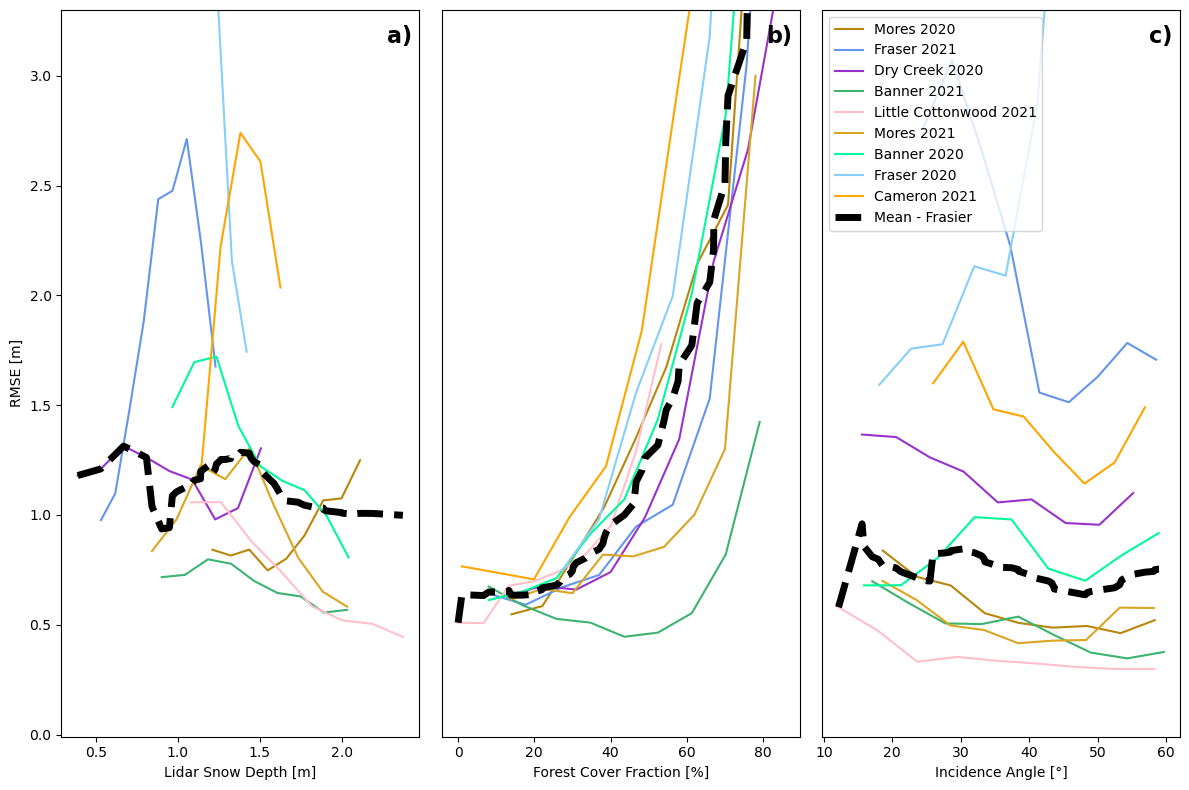

In [13]:
fig, axes = plt.subplots(1, 3, figsize = (12,8))

loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

x_labels = {'lidar-sd': 'Lidar Snow Depth [m]', 'fcf':'Forest Cover Fraction [%]', 's1':'Incidence Angle [°]'} # 'lidar-dem': 'Elevation [m]', , 'lidar-vh': 'Tree Height [m]'

for (var, label), ax in zip(x_labels.items(), axes.ravel()):

    ss = []
    f_ss = []
    for stem, ds in dss.items():
        # if 'Frasier' in stem.split('-')[0].replace('_', ' ') or 'Cameron' in stem:
            # continue
        # ds = ds.where(ds['wet_snow'] == 0)

        if var == 's1':
            time_ds = ds.sel(band = 'inc')
            time_ds['s1'] = time_ds['s1'].isel(time = slice(len(np.unique(time_ds.relative_orbit)))).mean(dim = 'time')
            # time_ds = time_ds.where(time_ds['lidar-dem'] > time_ds['lidar-dem'].quantile(0.5))

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        res = pd.Series(dtype = float)

        for cat, sub in time_ds.sel(band = 'inc').groupby_bins(var, np.linspace(*time_ds.sel(band = 'inc')[var].quantile([0.05, 0.95]).values.ravel(), 10)):

            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))

            if len(x[idx]) < 100:
                continue

            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx]) / np.nanmean(y[idx])

            if var == 's1':
                res.loc[np.rad2deg(cat.left)] = rmse_result / np.nanmean(x)
            elif var == 'lidar-sd':
                res.loc[cat.left] = rmse_result #/ np.nanmean(x)
            elif var == 'fcf':
                res.loc[cat.left * 100] = rmse_result
            else:
                res.loc[cat.left] = rmse_result
                    
        res.sort_index().plot(ax= ax, color = loc_colors[stem], label = stem.split('-')[0].replace('_', ' ').replace('Frasier', 'Fraser'))
        if 'Frasier' not in stem.split('-')[0].replace('_', ' '): # and 'Cameron' not in stem:
            ss.append(res.sort_index())
        else:
            f_ss.append(res.sort_index())
    
    # add mean line
    # vs = [10, 20, 30, 40,50, 60]
    # ss_new = [s.append(pd.Series({v:np.nan for v in vs})) for s in ss]
    if var == 'fcf':
        ss.extend(f_ss)
        df = pd.concat(ss, axis = 1).sort_index()
        df.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Mean - Frasier')
    else:
        df = pd.concat(ss, axis = 1).sort_index()
        df_f = pd.concat(f_ss, axis = 1).sort_index()
        df.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Mean - Frasier')
        # df_f.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Frasier')

    ax.set_xlabel(label)
    ax.set_ylim(-0.01, 3.3)
    print(var)
    # print((df.interpolate().mean(axis = 1).iloc[-1] - df.interpolate().mean(axis = 1).iloc[0])/ (df.interpolate().mean(axis = 1).index[-1] - df.interpolate().mean(axis = 1).index[0]))
    lm = linregress(x = df.interpolate().mean(axis = 1).index, y = df.interpolate().mean(axis = 1).values)
    print(f'Slope: {lm.slope}. p: {lm.pvalue}')
# axes[0].set_ylabel('NRMSE [m]')
axes[0].set_ylabel('RMSE [m]')
axes[-1].legend(loc='upper left',
    # bbox_to_anchor=(0.2, 1.08),
    ncol=1,
    # borderaxespad=0.15, 
    # fontsize=8,
    # frameon=False,
)

for ax in axes[1:]:
    ax.set_yticks([])

for ax, letter in zip(axes, ['a','b','c']):
    ax.text(0.98, 0.98,f'{letter})', transform=ax.transAxes, ha = 'right', va = 'top', weight='bold', size = 16)


plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors/rmse_binned.png')